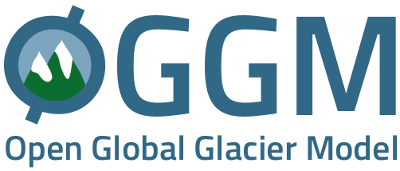

# Getting started with OGGM: a real case study, step by step

The OGGM workflow is best explained with an example. In the following, we will show how to apply the standard [OGGM workflow](http://docs.oggm.org/en/stable/introduction.html) to a list of glaciers.

### Input data folders

Before you start, make sure that you have set-up the [input data configuration file](https://docs.oggm.org/en/stable/input-data.html) at your wish.

In the course of this tutorial, we will download some of the data needed for a run, so make sure you have a decent internet connection. If you prefer not to download anything, refer to the other getting started guide: without data download (in construction).

### cfg.initialize() and cfg.PARAMS 

An OGGM simulation script will always start with the following commands:

In [1]:
from oggm import cfg
cfg.initialize()

2018-10-28 17:38:46: oggm.cfg: Using configuration file: /home/mowglie/Documents/git/oggm-official/oggm/params.cfg


A call to [cfg.initialize()](https://docs.oggm.org/en/latest/generated/oggm.cfg.initialize.html) will read the default parameter file (or any user-provided file) and make them available to all other OGGM tools via the `cfg.PARAMS` dictionary. Here are some example of these parameters:

In [2]:
cfg.PARAMS['prcp_scaling_factor'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']

(2.5, 900.0, False)

See [here](https://github.com/OGGM/oggm/blob/master/oggm/params.cfg) for the default parameter file and a description of their role and default value.

### Download the glacier outlines 

The glacier outlines are obtained from the [Randolph Glacier Inventory](https://www.glims.org/RGI/), the reference dataset for global and regional applications. The current version is V6, and OGGM ships with a slightly modified version which we called `61`. To download this version ([and related files), simply do:

In [14]:
from oggm import utils
utils.get_rgi_dir()  # this might take a couple of minutes!

'/home/mowglie/disk/OGGM_INPUT/rgi/RGIV61'

The folder above should now contain the glacier outlines in the [shapefile format](https://en.wikipedia.org/wiki/Shapefile), a format widely used in GIS applications. You can open the files with the tool of your choice ([geopandas](http://geopandas.org/) is a good choice in python), but OGGM comes with [handy tools](https://docs.oggm.org/en/latest/api.html#input-output) to read them for you. Here we use a convenience function to read one outline only:

In [4]:
rgi_df = utils.get_rgi_glacier_entities(['RGI60-11.01328'])

This gives us a data frame containing the glacier outlines and some useful attributes:

In [7]:
rgi_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
1327,RGI60-11.01328,G008219E46564N,20030799,20030999,8.2193,46.5642,11,1,23.825,1944,...,84,12635,0,0,0,0,9,9,None,"POLYGON ((8.171178630000043 46.53165119900007,..."


You don't need to bother much about the content of this file, since it is all OGGM needs to continue. `RGI60-11.01328` is the identifier of the [Unteraar Glacier](https://en.wikipedia.org/wiki/Unteraargletscher) in the Swiss Alps.

Before we continue, we need to tell OGGM one last thing

In [12]:
ddd = utils.get_rgi_intersects_region_file('11')

In [11]:
gpd.ge ddd

'/home/mowglie/disk/OGGM_INPUT/rgi/RGI_V61_Intersects/11_rgi61_CentralEurope/intersects_11_rgi61_CentralEurope.shp'

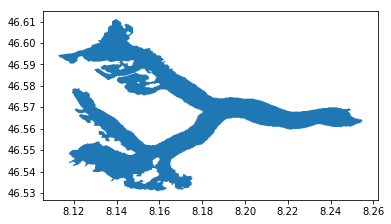

In [9]:
rgi_df.plot();

In the `test-workflow` directory you can have a look at the various files we will need. OGGM also needs them for testing, so they are automatically available to everybody with a simple mechanism:

In [ ]:

from oggm import utils
srtm_f = utils.get_demo_file('srtm_oetztal.tif')
rgi_f = utils.get_demo_file('rgi_oetztal.shp')
print(srtm_f)

The very first time that you make a call to `get_demo_file()`, OGGM will create a hidden `.oggm` directory in your home folder$^*$ and download the demo files in it.

<sub>*: this path might vary depending on your platform, see python's [expanduser](https://docs.python.org/3.5/library/os.path.html#os.path.expanduser)</sub>

### Digital elevation model (DEM) and glacier outlines

The data directory contains a subset of the [RGI](https://www.glims.org/RGI/) (V5) for the Ötztal:

In [ ]:
import geopandas as gpd
rgi_shp = gpd.read_file(rgi_f).set_index('RGIId')

We'll have a look at it, but first we will need to make some imports and set some defaults:

In [ ]:
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
# Packages
import os
import numpy as np
import xarray as xr
import shapely.geometry as shpg
plt.rcParams['figure.figsize'] = (8, 8)  # Default plot size

Plot the glaciers of the Ötztal case study:

In [ ]:
rgi_shp.plot(edgecolor='black')
plt.ylabel('latitude')
plt.xlabel('longitude');

### Calibration / validation data

These 20 glaciers were selected because they have either mass-balance data (WGMS) or total volume information (GlaThiDa). These data are required for calibration/validation and are available automatically in OGGM.

### Climate data

For this test case we use [HISTALP](https://docs.oggm.org/en/latest/mass-balance.html?highlight=histalp#histalp) data (which goes back further in time than CRU), stored in the NetCDF format. The resolution of HISTALP (5 minutes of arc) is relatively high, but some kind of downscaling will be necessary to compute the mass-balance at the glacier scale.

We can plot a timeseries of the data, for example for the grid point (3, 3):

In [ ]:
fig = plt.figure(figsize=(9, 3))
with xr.open_dataset(utils.get_demo_file('HISTALP_oetztal.nc')) as ds:
    ds.temp[:, 3, 3].resample(time="AS").mean().plot()
    plt.title('HISTALP annual temperature (°C)');

## Setting up an OGGM run

OGGM parameters are gathered in a configuration file. The [default file](https://github.com/OGGM/oggm/blob/master/oggm/params.cfg) is shipped with the code. It is used to initialize the configuration module:

In [ ]:
from oggm import cfg
from oggm import workflow
cfg.initialize()  # read the default parameter file

For example, the `cfg` module has a global variable `PATHS` (a dictionary) storing the file paths to the data and working directories:

In [ ]:
cfg.PATHS

The path to the working directory and the input data files are missing. Let's set them so that the OGGM modules know where to look for them (the default would be to download them automatically, which we would like to avoid for this example):

In [ ]:
cfg.PATHS['working_dir'] = os.path.expanduser('~/OGGM_Getting_Started_wd')

In [ ]:
cfg.PATHS['dem_file'] = utils.get_demo_file('srtm_oetztal.tif')
cfg.PATHS['climate_file'] = utils.get_demo_file('HISTALP_oetztal.nc')
cfg.PARAMS['baseline_climate'] = 'CUSTOM'
cfg.set_intersects_db(utils.get_demo_file('rgi_intersect_oetztal.shp'))

We will set the "border" option to a larger value, since we will do some dynamical simulations ("border" decides on the number of DEM grid points we'd like to add to each side of the glacier for the local map: the larger the glacier will grow, the larger the border should be):

In [ ]:
cfg.PARAMS['border'] = 80

We keep the other parameters to their default values, for example the precipitation scaling factor:

In [ ]:
cfg.PARAMS['prcp_scaling_factor']

## Glacier working directories

An OGGM "run" is made of several successive tasks to be applied on each glacier. Because these tasks can be computationally expensive they are split in smaller tasks, each of them storing their results in a [glacier directory](http://docs.oggm.org/en/latest/glacierdir.html).

The very first task of an OGGM run is always `init_glacier_regions`:

In [ ]:
# Read in the RGI file
import geopandas as gpd
rgi_file = utils.get_demo_file('rgi_oetztal.shp')
rgidf = gpd.read_file(rgi_file)
# Initialise directories
# reset=True will ask for confirmation if the directories are already present: 
# this is very useful if you don't want to loose hours of computations because of a command gone wrong
gdirs = oggm.workflow.init_glacier_regions(rgidf, reset=True, force=True)

Note that if I run `init_glacier_regions` a second time without `reset=True`, nothing special happens. The directories will not be overwritten, just "re-opened":

In [ ]:
gdirs = workflow.init_glacier_regions(rgidf)

Now what is the variable `gdirs`? It is a list of 20 [GlacierDirectory](http://docs.oggm.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects. They are here to help us to handle data input/output and to store several glacier properties. Here are some examples: 

In [ ]:
gdir = gdirs[13]
gdir

`gdir` provides a `get_filepath` function which gives access to the data files present in the directory:

In [ ]:
gdir.get_filepath('dem')

`dem.tif` is a local digital elevation map with a spatial resolution chosen by OGGM as a function of the glacier size. These [GlacierDirectory](http://docs.oggm.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects are going to be the input of almost every OGGM task.

The advantage of this data model is that it can obtain several input data by just using one single argument. This data is obtained from the disk. For example glacier location and glacier outlines are needed for the next plot and are called by the single argument 'gdir'.

In [ ]:
from oggm import graphics
graphics.plot_googlemap(gdir)

## OGGM tasks

The workflow of OGGM is oriented around the concept of "[tasks](http://docs.oggm.org/en/latest/api.html#entity-tasks)". There are two different types:

**Entity Task**:
  Standalone operations to be realized on one single glacier entity,
  independently from the others. The majority of OGGM
  tasks are entity tasks. They are parallelisable.

**Global Task**:
  Tasks which require to work on several glacier entities
  at the same time. Model parameter calibration or interpolation of degree day factors belong to
  this type of task. They are not parallelisable.
  
OGGM implements a simple mechanism to run a specific task on a list of `GlacierDir` objects (here, the function `glacier_masks()` from the module `oggm.prepro.gis`):

In [ ]:
from oggm import tasks

In [ ]:
# run the glacier_masks task on all gdirs
workflow.execute_entity_task(tasks.glacier_masks, gdirs);

We just computed gridded boolean [masks](http://docs.oggm.org/en/latest/generated/oggm.tasks.glacier_masks.html#oggm.tasks.glacier_masks) out of the RGI outlines.

It is also possible to apply several tasks sequentially:

In [ ]:
list_talks = [
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_line,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

The function `execute_task` can run a task on different glaciers at the same time, if the `use_multiprocessing` option is set to `True` in the configuration file. 

With all these tasks we just computed the glacier flowlines (bold line) and their widths (thin lines). See the [docu](http://docs.oggm.org/en/latest/flowlines.html#flowline-widths) for more info:

In [ ]:
graphics.plot_catchment_width(gdir, corrected=True)

### Global tasks, climate tasks

We will go into more detail about tasks in the [documentation about mass balance](https://docs.oggm.org/en/latest/mass-balance.html). For now, we will use the helper function:

In [ ]:
# We calibrate tstars ourselves
cfg.PARAMS['run_mb_calibration'] = True
workflow.climate_tasks(gdirs)

We just read the climate data, "downscaled" it to each glacier, computed possible $\mu^*$ for the reference glaciers, picked the best one, interpolated the corresponding $t^*$ to glaciers without mass-balance observations, computed the mass-balance sensitivity $\mu$ for all glaciers and finally computed the mass-balance at equilibrium (the "apparent mb" in Farinotti et al., 2009).

## Computing the ice thickness (Inversion)

This is where things become a bit more complicated. The inversion is already fully automated in OGGM, but there is not yet a generally accepted way to calibrate it. For this tutorial we will try to explain in more detail what is happening.

### Default parameters

Let's start with the default, which is to use the standard ice creep parameter A and no sliding:

In [ ]:
list_talks = [
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

Let's see what we have:

In [ ]:
# Select HEF out of all glaciers
gdir_hef = [gd for gd in gdirs if (gd.rgi_id == 'RGI50-11.00897')][0]
graphics.plot_inversion(gdir_hef)

The computed volume of Hintereisferner is 0.77 km$^{3}$ (for 2003, which is the date for the outlines). According to [Fisher et al., 2013](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/27F001E11BA6AC163A3D31F5C1448853/S0260305500259752a.pdf/groundpenetrating_radar_measurements_of_64_austrian_glaciers_between_1995_and_2010.pdf), this volume should be 0.573 km$^{3}$ for 2001, which is a bit less then computed for 2003. This is not too surprising, since we use a default setting and no basal sliding, all this is likely to overestimate the thickness.

### Inversion model sensitivity 

How sensitive is the inversion to changes in the A parameter?

In [ ]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = tasks.mass_conservation_inversion(gdir_hef, glen_a=cfg.PARAMS['glen_a']*f, print_log=False)
    thick[i] = vol_m3/area_m3
plt.figure(figsize=(6, 4))
plt.plot(factor, thick);
plt.ylabel('Mean thickness (m)');
plt.xlabel('A Multiplier');

The shape of the curve is explained by the physics of ice. As you can see, tuning this parameter is not an easy task.

### Finalize the inversion 

In [ ]:
# For the rest of the examples, we don't use the optimal parameters but the default ones
cfg.PARAMS['optimize_inversion_params'] = False
workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs)
workflow.execute_entity_task(tasks.filter_inversion_output, gdirs)

The results of the inversion (and other useful parameters) can be combined with a utilitary function:

In [ ]:
df = utils.compile_glacier_statistics(gdirs)
ax = df.plot.scatter(x='rgi_area_km2', y='inv_volume_km3', color='C3')
ax.semilogx(); ax.semilogy();

## Dynamics 

For the dynamics refer to the other notebooks in the same folder!

## Set up a run 

For setting up a real OGGM run with your own data, refer to [the documentation](http://docs.oggm.org/en/latest/run.html)!